In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [1]:
import os
import glob
import cv2
from PIL import Image
import tensorflow as tf
from mlxtend.plotting import plot_decision_regions
import warnings
from scipy.stats import uniform, expon, randint

from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.models import load_model, save_model, Model
from keras.layers import Flatten, Dense, Conv2D, Dropout, BatchNormalization, AveragePooling2D, LeakyReLU, GlobalAveragePooling2D, MaxPooling2D, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.efficientnet_v2 import preprocess_input as preprocess_input_efficientnet
from keras.applications import EfficientNetV2L
from keras.applications.mobilenet_v3 import MobileNetV3Large
from keras.applications.mobilenet_v3 import preprocess_input as preprocess_input_mobilenet
from keras import regularizers

if str(os.getcwdb()[-3:]).split("'")[1] != 'src':
    for _ in range(2):
        os.chdir(os.path.dirname(os.getcwdb()))

from utils.classes import *
from utils.functions import *

# import pandas as pd
# from sklearn.model_selection import train_test_split
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
# import joblib


In [2]:
processed_images_path = r'data\processed\images'
df_images_data_original = pd.read_csv(r'data\processed\images_data_processed.csv')

# df_images_data_original = pd.read_csv('/content/gdrive/My Drive/images_data_processed.csv')
# processed_images_path = r'/content/gdrive/My Drive/images'

df_images_data_original.head()


Id    Shape  Weight Clarity Colour Cut Polish Symmetry Fluorescence  \
0  1638147  CUSHION    0.55     SI2      E  EX     EX       VG            N   
1  1630155  CUSHION    0.50    VVS1  FANCY  EX     EX       VG            F   
2  1612606  CUSHION    0.51     VS2      H  EX     EX       VG            N   
3  1638140  CUSHION    0.50     VS2      H  EX     EX       VG            N   
4  1536093  CUSHION    0.53     SI1      D  EX     VG       VG            N   

     Messurements    price  
0  5.05-4.35×2.94  1378.65  
1  4.60-4.31×2.92  1379.74  
2  4.71-4.35×2.94  1380.19  
3  4.91-4.26×2.88  1380.61  
4  4.70-4.46×3.01  1383.13

# Modelo provisional: MobilenetV3Large

- Se prueban muchos modelos (VGG16, Resnet50...) con sus diferentes versiones, pero no se guardan porque el código es largo y complicaría innecesariamente la revisión del "notebook". La arquitectura y el funcionamiento es similar, solo cambia el tamaño del "input"

- Al final, se utiliza un modelo MobileNetV3Large, que es potente, relativamente moderno, de una fuente confiable (Google), y que se ha demostrado eficaz para la detección de imágenes

- Como es muy lento, se pone en marcha en Google Collab y se aprovecha la GPU. Las partes del código solo usadas en Collab se encuentran comentadas

- Como la predicción no es muy buena, se considera provisional. Un segundo modelo usará esa predicción junto con el peso de los diamantes para obtener un precio más ajustado a la realidad

## Ejecución

In [ ]:
# Se adaptan las imágenes al tamaño correcto para el "input"
for image_path in glob.glob(processed_images_path+'/*.jpg'):
    with Image.open(image_path) as image:
        image = image.resize((224, 224))
        image.save(image_path)


In [3]:
# Se lleva a cabo un escalado y modificación de la "Id" para que las imágenes sean reconocibles para el "generator" a partir del "dataframe"
df_images_data = df_images_data_original.copy()

df_images_data = df_images_data[['Id', 'price']]

df_images_data['Id'] = df_images_data['Id'].apply(lambda x: x + '.jpg')

scaler = StandardScaler()

df_images_data['price'] = scaler.fit_transform(df_images_data[['price']])

df_images_data.head()


Id     price
0  1638147.jpg -0.579172
1  1630155.jpg -0.577234
2  1612606.jpg -0.576434
3  1638140.jpg -0.575688
4  1536093.jpg -0.571209

In [4]:
# Se crean dos "dataframes", uno de "train" y uno de "test"
X_train, X_test, y_train, y_test = train_test_split(df_images_data['Id'], df_images_data.drop(columns='Id'), train_size=0.8, random_state=42)

df_train = pd.concat((X_train, y_train), axis=1)
df_test = pd.concat((X_test, y_test), axis=1)

df_train.head()


Id     price
665   1638121.jpg  1.478931
4058  1770787.jpg  0.639604
3929  1784542.jpg  0.611201
910   1771151.jpg -0.672559
1074  1794356.jpg -0.982687

In [7]:
# Se prepara la "augmentation" de las imágenes. Nótese el detalle de que, dado que el diamante es lo único realmente visible y relevante, el fondo desconocido tras las rotaciones se rellena con el color del fondo real
data_augmentation = ImageDataGenerator(rotation_range=20,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        zoom_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        validation_split=0.3,
                                        fill_mode='constant',
                                        cval=(176+177+181) / 3,
                                        preprocessing_function=preprocess_input_mobilenet
                                        )


In [8]:
# Se ponen en marcha los generadores
train_generator = data_augmentation.flow_from_dataframe(dataframe=df_train,
                                                        directory=processed_images_path,
                                                        target_size=(224, 224),
                                                        class_mode='raw',
                                                        shuffle=False,
                                                        x_col='Id',
                                                        y_col=list(df_images_data.columns[1:]),
                                                        seed=42,
                                                        subset='training',
                                                        batch_size=256
                                                        )

validation_generator = data_augmentation.flow_from_dataframe(dataframe=df_train,
                                                                directory=processed_images_path,
                                                                target_size=(224, 224),
                                                                class_mode='raw',
                                                                shuffle=False,
                                                                x_col='Id',
                                                                y_col=list(df_images_data.columns[1:]),
                                                                seed=42,
                                                                subset='validation',
                                                                batch_size=256
                                                                )

test_generator = data_augmentation.flow_from_dataframe(dataframe=df_test,
                                                        directory=processed_images_path,
                                                        target_size=(224, 224),
                                                        class_mode='raw',
                                                        shuffle=False,
                                                        x_col='Id',
                                                        y_col=list(df_images_data.columns[1:]),
                                                        seed=42,
                                                        batch_size=256
                                                        )


Found 2399 validated image filenames.
Found 1028 validated image filenames.
Found 857 validated image filenames.


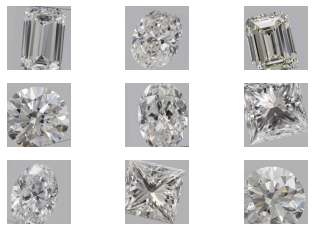

In [ ]:
# Se visualizan algunas de las imágenes creadas
augmented_images, _ = train_generator.next()
augmented_images /= 255

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.show()


In [ ]:
# Se comprueba la GPU
# print(tf.test.gpu_device_name())


/device:GPU:0


In [9]:
# Se prepara la arquitectura y se entrena y modifica la capa superior del modelo
tf.random.set_seed(42)

base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

top_model = base_model.output

top_model = GlobalAveragePooling2D()(top_model)

top_model = Dense(1024, activation='relu')(top_model)

top_model = Dense(512, activation='relu')(top_model)

top_model = Dense(256, activation='relu')(top_model)

top_model = Dense(128, activation='relu')(top_model)

top_model = Dense(64, activation='relu')(top_model)

top_model = Dense(32, activation='relu')(top_model)

top_model = Dense(16, activation='relu')(top_model)

top_model = Dense(8, activation='relu')(top_model)

output_layer = Dense(1, activation='linear')(top_model)

model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# el "with" es solo para Collab, donde se usa la GPU para almacenar las imágenes
# with tf.device('/device:GPU:0'):
history = model.fit(train_generator,
                    epochs=100,
                    batch_size=128,
                    validation_data=validation_generator,
                    callbacks=[early_stop, reduce_lr]
                    )


12683000/12683000 [==============================] - 2s 0us/step
Epoch 1/100
10/10 [==============================] - 1911s 194s/step - loss: 0.8453 - val_loss: 0.7015 - lr: 0.0010
Epoch 2/100
10/10 [==============================] - 38s 4s/step - loss: 0.6462 - val_loss: 0.6092 - lr: 0.0010
Epoch 3/100
10/10 [==============================] - 38s 4s/step - loss: 0.5767 - val_loss: 0.6279 - lr: 0.0010
Epoch 4/100
10/10 [==============================] - 38s 4s/step - loss: 0.5576 - val_loss: 0.6071 - lr: 0.0010
Epoch 5/100
10/10 [==============================] - 38s 4s/step - loss: 0.5504 - val_loss: 0.5959 - lr: 0.0010
Epoch 6/100
10/10 [==============================] - 38s 4s/step - loss: 0.5444 - val_loss: 0.5770 - lr: 0.0010
Epoch 7/100
10/10 [==============================] - 38s 4s/step - loss: 0.5295 - val_loss: 0.5892 - lr: 0.0010
Epoch 8/100
10/10 [==============================] - 38s 4s/step - loss: 0.5461 - val_loss: 0.5715 - lr: 0.0010
Epoch 9/100
10/10 [================

In [10]:
# Se visualizan las predicciones. Son mejorables
y_pred = model.predict(test_generator)
y_pred = scaler.inverse_transform(y_pred)

metrics_dict = dict()
for index, col in enumerate(df_images_data.columns[1:]):
    rmse = mean_squared_error([row[index] for row in scaler.inverse_transform(test_generator.labels)], [row[index] for row in y_pred], squared=False)
    mse = mean_squared_error([row[index] for row in scaler.inverse_transform(test_generator.labels)], [row[index] for row in y_pred])
    mae = mean_absolute_error([row[index] for row in scaler.inverse_transform(test_generator.labels)], [row[index] for row in y_pred])
    r2 = r2_score([row[index] for row in scaler.inverse_transform(test_generator.labels)], [row[index] for row in y_pred])
    mape = mean_absolute_percentage_error([row[index] for row in scaler.inverse_transform(test_generator.labels)], [row[index] for row in y_pred])
    metrics_dict[col] = {'mse': mse,
                            'rmse': rmse,
                            'mae': mae,
                            'r2': r2,
                            'mape': mape
                         }

metrics_dict


4/4 [==============================] - 475s 157s/step


{'price': {'mse': 159148.93149334853,
  'rmse': 398.9347459088372,
  'mae': 289.7887980618026,
  'r2': 0.4880533714163491,
  'mape': 0.19869874196174445}}

In [11]:
df_price = pd.DataFrame(data={'Original': [row[0] for row in scaler.inverse_transform(test_generator.labels)], 'Prediction': [row[0] for row in y_pred]})

df_price


Original   Prediction
0     1788.05  1893.134399
1     1497.46  1966.037964
2     2032.24  1920.503906
3     2039.59  2030.276001
4     1407.85  1301.085815
..        ...          ...
852   2123.92  1984.700195
853   1458.81  1502.853027
854   2448.28  2002.525635
855   2223.08  1792.144287
856   1515.12  1998.935547

[857 rows x 2 columns]

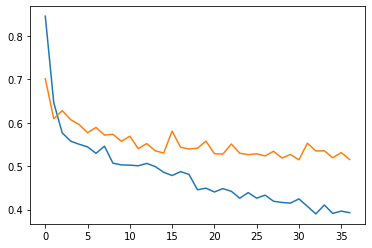

In [12]:
# Se visualiza la gráfica de pérdida
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.show()


## Guardado del modelo

- Se guarda el modelo para poder trabajarlo en local

In [13]:
# Se guarda el modelo para poder trabajarlo en local
# save_model(model, '/content/gdrive/My Drive/price_prediction_images.h5')


## Guardado del "test"

- Se intentará mejorar los precios a partir de las predicciones de la red neuronal. Por tanto, hay que trabajar con el que es el "test" en ese modelo

- Para que los resultados sean reproducibles exactamente iguales fuera de este "notebook" de "collab", se guarda el "dataframe" en "pickle". De lo contrario, como el "generator" devuelve distintas imágenes cada vez, el resultado será similar pero no el mismo

In [14]:
# df_images_data = df_images_data_original.copy()

# df_images_data = df_images_data[['Id', 'Weight', 'price']]

# df_images_data['Id'] = df_images_data['Id'].apply(lambda x: x + '.jpg')

# df_images_data.head()


Id  Weight    price
0  1638147.jpg    0.55  1378.65
1  1630155.jpg    0.50  1379.74
2  1612606.jpg    0.51  1380.19
3  1638140.jpg    0.50  1380.61
4  1536093.jpg    0.53  1383.13

In [15]:
# previously_predicted_price = model.predict(test_generator)

# df_images_weight = pd.DataFrame(data={'Id': test_generator.filenames, 
#                                           'predicted_price': previously_predicted_price[:, 0].tolist(),
#                                           'original_price': test_generator.labels[:, 0].tolist()
#                                           }
#                                    )

# df_images_weight


4/4 [==============================] - 9s 2s/step


Id  predicted_price  original_price
0    1764023.jpg         0.619295        0.148514
1    1782057.jpg         0.530404       -0.367994
2    1747623.jpg         0.314935        0.582548
3    1758822.jpg         0.593161        0.595612
4    1782615.jpg        -0.740192       -0.527270
..           ...              ...             ...
852  1658278.jpg         0.272178        0.745504
853  1793429.jpg        -0.203773       -0.436692
854  1624339.jpg         0.663083        1.322036
855  1593512.jpg         0.232014        0.921756
856  1741629.jpg         0.564665       -0.336604

[857 rows x 3 columns]

In [16]:
# df_images_weight = pd.merge(df_images_weight, df_images_data, on=['Id'], how='left')

# df_images_weight.head()


Id  predicted_price  original_price  Weight    price
0  1764023.jpg         0.619295        0.148514    0.50  1788.05
1  1782057.jpg         0.530404       -0.367994    0.50  1497.46
2  1747623.jpg         0.314935        0.582548    0.50  2032.24
3  1758822.jpg         0.593161        0.595612    0.52  2039.59
4  1782615.jpg        -0.740192       -0.527270    0.50  1407.85

In [17]:
# df_images_weight = df_images_weight[['predicted_price', 'Weight', 'original_price']]

# df_images_weight.head()


predicted_price  Weight  original_price
0         0.619295    0.50        0.148514
1         0.530404    0.50       -0.367994
2         0.314935    0.50        0.582548
3         0.593161    0.52        0.595612
4        -0.740192    0.50       -0.527270

In [18]:
# joblib.dump(df_images_weight, '/content/gdrive/My Drive/fixed_images_dataframe.pkl')

# df_images_weight_imported = joblib.load('/content/gdrive/My Drive/fixed_images_dataframe.pkl')

# df_images_weight_imported.head()


predicted_price  Weight  original_price
0         0.619295    0.50        0.148514
1         0.530404    0.50       -0.367994
2         0.314935    0.50        0.582548
3         0.593161    0.52        0.595612
4        -0.740192    0.50       -0.527270

In [5]:
df_images_weight = joblib.load('fixed_images_dataframe.pkl')

df_images_weight.head()


predicted_price  Weight  original_price
0         0.619295    0.50        0.148514
1         0.530404    0.50       -0.367994
2         0.314935    0.50        0.582548
3         0.593161    0.52        0.595612
4        -0.740192    0.50       -0.527270

# Modelo definitivo: SVR

- Se decide crear un modelo de "machine learning" que trate de mejorar la predicción del precio de los diamantes a partir del peso y de la predicción provisional hecha anteriormente por la red neuronal. Se hace así por ser más transparentes que las redes neuronales, lo que permite elegir uno u otro en función del comportamiento de los datos más fácilmente

- Se hace un "baseline" de modelos supervisados, se encuentra que SVR es el más adecuado por tener buenas métricas y poca variación, y se optimiza con el "kernel" lineal para aproximar el aumento del precio de los diamantes al subir su peso, así como para tener en cuenta que la predicción final debería crecer a medida que la provisional aumenta

- Si bien el precio de los diamantes en relación a su peso es exponencial, eso solo es determinante cuando el peso de los diamantes es elevado. Para diamantes pequeños, puede considerarse que es casi lineal; de ahí que se seleccione SVR con ese "kernel" (los diamantes de los que se dispone no son muy grandes en su mayoría)


## Baseline de "machine learning"

- El mejor modelo para predecir el precio a partir de la estimación hecha por el modelo de "transfer learning" y el peso sería un SVR. No solo obtiene la mejor puntuación para la mayoría de las métricas, sino que también se encuentra entre los que tienen menos varianza. Además, trabaja mejor con valores fuera de los rangos vistos durante el entrenamiento que los modelos de árboles

In [6]:
Regression.add_models('LinearRegression',
                        'Ridge',
                        'DecisionTreeRegressor',
                        'KNeighborsRegressor',
                        'RandomForestRegressor',
                        'SVR',
                        'XGBRegressor'
                        )

Regression.chosen_models


{'LinearRegression': '',
 'Ridge': '',
 'DecisionTreeRegressor': '',
 'KNeighborsRegressor': '',
 'RandomForestRegressor': '',
 'SVR': '',
 'XGBRegressor': ''}

In [7]:
baseline = Regression(df_images_weight, 'original_price')
X_train, X_test, y_train, y_test = baseline.split_dataframe()
baseline.prepare_models(params_list=[['DecisionTreeRegressor', 'random_state=43'],
                                    ['RandomForestRegressor', 'random_state=43'],
                                    ['XGBRegressor', 'random_state=43']
                                    ])
baseline.apply_and_evaluate_kfolds()
baseline.create_dataframe()


-- Regression: using mean of 5 folds --
Starting LinearRegression:
- LinearRegression done in 0.05 sec(s). Total time: 0.05
Starting Ridge:
- Ridge done in 0.04 sec(s). Total time: 0.09
Starting KNeighborsRegressor:
- KNeighborsRegressor done in 0.04 sec(s). Total time: 0.13
Starting SVR:
- SVR done in 0.16 sec(s). Total time: 0.29
Starting DecisionTreeRegressor: random_state=43:
- DecisionTreeRegressor: random_state=43 done in 0.06 sec(s). Total time: 0.35
Starting RandomForestRegressor: random_state=43:
- RandomForestRegressor: random_state=43 done in 2.77 sec(s). Total time: 3.13
Starting XGBRegressor: random_state=43:
- XGBRegressor: random_state=43 done in 0.42 sec(s). Total time: 3.55


LinearRegression     Ridge  KNeighborsRegressor       SVR  \
rmse              0.610802  0.611215             0.599347  0.576906   
mse               0.375313  0.375786             0.362191  0.333709   
mae               0.479085  0.478957             0.433187  0.414817   
r2_score          0.615272  0.614676             0.627706  0.656452   
mape              1.305247  1.300185             1.171532  1.274407   

          DecisionTreeRegressor: random_state=43  \
rmse                                    0.780395   
mse                                     0.610785   
mae                                     0.540577   
r2_score                                0.370993   
mape                                    1.797915   

          RandomForestRegressor: random_state=43  \
rmse                                    0.633290   
mse                                     0.402729   
mae                                     0.454931   
r2_score                                0.585630   
mape                                    1.349225   

          XGBRegressor: random_state=43                 BEST  \
rmse                           0.688889                  SVR   
mse                            0.476098                  SVR   
mae                            0.484284                  SVR   
r2_score                       0.509908                  SVR   
mape                           1.479261  KNeighborsRegressor   

                                           WORST  
rmse      DecisionTreeRegressor: random_state=43  
mse       DecisionTreeRegressor: random_state=43  
mae       DecisionTreeRegressor: random_state=43  
r2_score           XGBRegressor: random_state=43  
mape      DecisionTreeRegressor: random_state=43

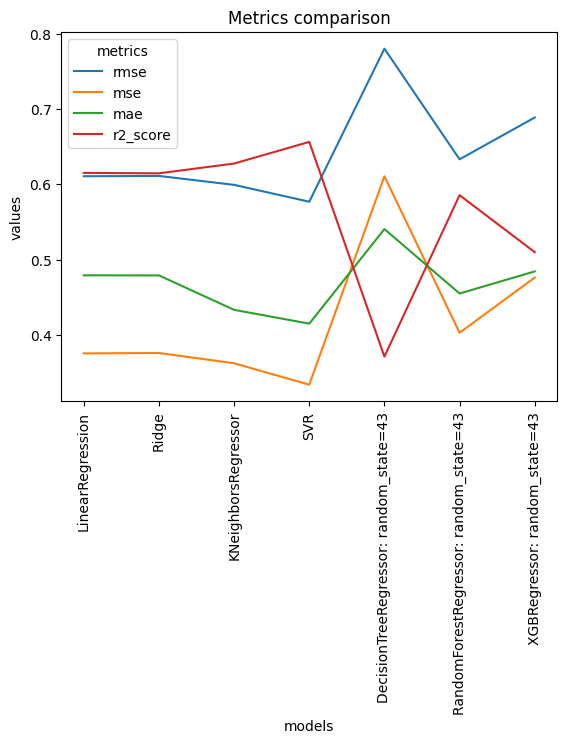

In [7]:
baseline.visualize('rmse', 'mse', 'r2_score', 'mae')


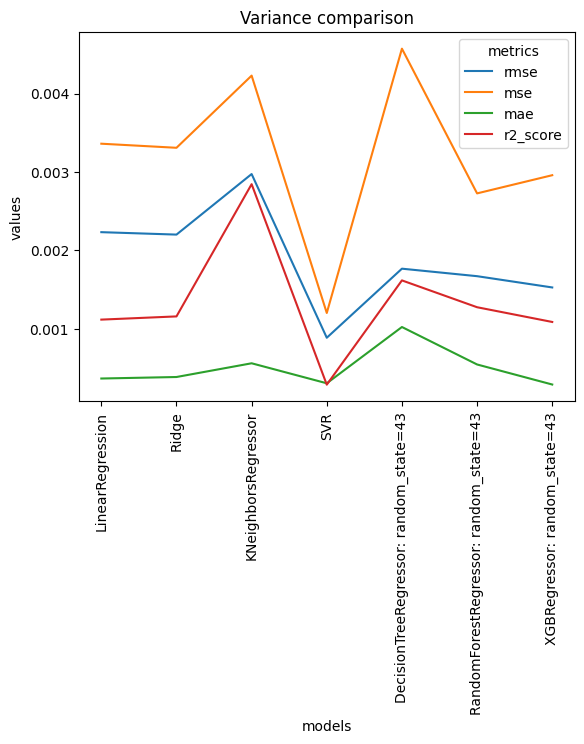

In [9]:
baseline.create_dataframe(chosen_format='variance')
baseline.visualize('rmse', 'mse', 'r2_score', 'mae')


## Optimización SVR

- Se buscan los mejores parámetros para la predicción

- El modelo resultante predice mejor que la red neuronal sola

In [8]:
kfolds = KFold(n_splits=5, shuffle=True, random_state=43)
rmse = make_scorer(calculate_rmse, greater_is_better=False)


In [9]:
for kernel in ['poly', 'rbf', 'sigmoid','linear']:
    svr = SVR(kernel=kernel) 
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_test)
    print('\n')
    print(kernel)
    print(f'rmse: {mean_squared_error(y_test, y_pred, squared=False)}')
    print(f'mse: {mean_squared_error(y_test, y_pred)}')
    print(f'mae: {mean_absolute_error(y_test,y_pred)}')
    print(f'r2: {r2_score(y_test, y_pred)}')
    print(f'mape: {mean_absolute_percentage_error(y_test, y_pred)}')




poly
rmse: 0.750006678594137
mse: 0.5625100179358092
mae: 0.5623163857320995
r2: 0.4368476721776271
mape: 6.656622936495686


rbf
rmse: 0.5917290079150169
mse: 0.35014321880809013
mae: 0.40102891564672516
r2: 0.6494569652882234
mape: 29.225960265005


sigmoid
rmse: 23.279589933424433
mse: 541.9393074683962
mae: 17.934493181002292
r2: -541.5581284031447
mape: 2495.528747697208


linear
rmse: 0.6358397085753454
mse: 0.4042921350011803
mae: 0.4605883058735968
r2: 0.5952462184021527
mape: 18.538182618844992


### "RandomizedSearch"

- Se empieza con una prueba aleatoria para aproximar los mejores hiperparámetros. A pesar de sus limitaciones, se elige el "kernel" de tipo "linear" ya que, si bien el precio de los diamantes sube de forma exponencial en relación a su peso, en pequeño tamaño esa relación se puede aproximar a una lineal. Además, a mayor predicción previa por parte de la red neuronal, mayor debería ser el precio final

In [12]:
model = SVR()

params= {'C': uniform(loc=0, scale=10),
            'epsilon': uniform(loc=0, scale=1),
            'shrinking': [True, False],
            'tol': uniform(loc=0, scale=0.1),
            'kernel': ['linear']
            }

grid = RandomizedSearchCV(estimator=model,
                            param_distributions=params,
                            scoring=rmse,
                            verbose=4,
                            cv=kfolds,
                            n_iter=5000,
                            random_state=42
                            )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 5000 candidates, totalling 25000 fits
[CV 1/5] END C=3.745401188473625, epsilon=0.9507143064099162, kernel=linear, shrinking=True, tol=0.07796910002727693;, score=-0.570 total time=   0.0s
[CV 2/5] END C=3.745401188473625, epsilon=0.9507143064099162, kernel=linear, shrinking=True, tol=0.07796910002727693;, score=-0.553 total time=   0.0s
[CV 3/5] END C=3.745401188473625, epsilon=0.9507143064099162, kernel=linear, shrinking=True, tol=0.07796910002727693;, score=-0.625 total time=   0.0s
[CV 4/5] END C=3.745401188473625, epsilon=0.9507143064099162, kernel=linear, shrinking=True, tol=0.07796910002727693;, score=-0.663 total time=   0.0s
[CV 5/5] END C=3.745401188473625, epsilon=0.9507143064099162, kernel=linear, shrinking=True, tol=0.07796910002727693;, score=-0.677 total time=   0.0s
[CV 1/5] END C=5.96850157946487, epsilon=0.44583275285359114, kernel=linear, shrinking=True, tol=0.005808361216819946;, score=-0.546 total time=   0.0s
[CV 2/5] END C=5.9685015794

### "GridSearch"

- Se itentan acotar los parámetros ganadores del "RandomSearch" con algunos "GridSearch"

In [15]:
model = SVR()

params= {'C': [3.01, 3.02, 3.03, 3.04, 3.05, 3.06, 3.07, 3.08, 3.09],
            'epsilon': [0.511, 0.512, 0.513, 0.514, 0.515, 0.516, 0.517, 0.518, 0.519],
            'kernel': ['linear'],
            'shrinking': [True],
            'tol': [0.01, 0.02,0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09],
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[CV 1/5] END C=3.01, epsilon=0.511, kernel=linear, shrinking=True, tol=0.01;, score=-0.548 total time=   0.0s
[CV 2/5] END C=3.01, epsilon=0.511, kernel=linear, shrinking=True, tol=0.01;, score=-0.565 total time=   0.0s
[CV 3/5] END C=3.01, epsilon=0.511, kernel=linear, shrinking=True, tol=0.01;, score=-0.601 total time=   0.0s
[CV 4/5] END C=3.01, epsilon=0.511, kernel=linear, shrinking=True, tol=0.01;, score=-0.655 total time=   0.0s
[CV 5/5] END C=3.01, epsilon=0.511, kernel=linear, shrinking=True, tol=0.01;, score=-0.671 total time=   0.0s
[CV 1/5] END C=3.01, epsilon=0.511, kernel=linear, shrinking=True, tol=0.02;, score=-0.550 total time=   0.0s
[CV 2/5] END C=3.01, epsilon=0.511, kernel=linear, shrinking=True, tol=0.02;, score=-0.564 total time=   0.0s
[CV 3/5] END C=3.01, epsilon=0.511, kernel=linear, shrinking=True, tol=0.02;, score=-0.601 total time=   0.0s
[CV 4/5] END C=3.01, epsilon=0.511, kernel=linear, shrin

### Resolución

- Se obtienen los mejores hiperparámetros y se evalúa el resultado

In [17]:
# Estos son los mejores hiperparámetros
final_model = SVR(C=3.02,
                  epsilon=0.516,
                  kernel='linear',
                  shrinking=True,
                  tol=0.04
                    )

final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)


In [18]:
y_pred = np.round(scaler.inverse_transform(y_pred.reshape(-1, 1)), 2)
y_test = scaler.inverse_transform(y_test.values.reshape(-1, 1))
previous_price = scaler.inverse_transform(X_test[['predicted_price']])


In [19]:
df_price = pd.DataFrame(data={'Original': [row[0] for row in y_test], 'Prediction': [row[0] for row in y_pred]})

df_price

Original  Prediction
0     2088.84     1820.22
1     1103.49      981.32
2     1578.46     1946.95
3     1093.95      962.68
4     1264.82     1613.96
..        ...         ...
253   1525.93     2028.14
254    897.05     1478.30
255   2044.11     1736.55
256   2352.39     1846.40
257   1876.75     1729.33

[258 rows x 2 columns]

In [20]:
# Estas son las mejores métricas posibles
print(f'rmse: {mean_squared_error(y_test, y_pred, squared=False)}')
print(f'mse: {mean_squared_error(y_test, y_pred)}')
print(f'mae: {mean_absolute_error(y_test,y_pred)}')
print(f'r2: {r2_score(y_test, y_pred)}')
print(f'mape: {mean_absolute_percentage_error(y_test, y_pred)}')


rmse: 346.6545270138915
mse: 120169.3610992248
mae: 260.2631007751938
r2: 0.6199144200846692
mape: 0.17561743242938072


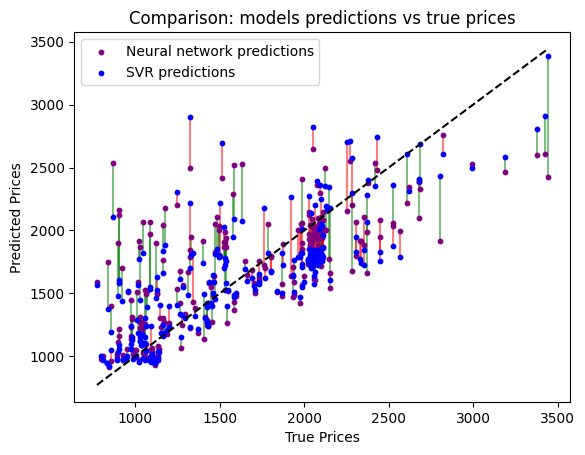

In [21]:
# Aquí puede verse cómo el SVR modifica las predicciones previas de la red neuronal. Las línes verdes indican una mejora
fig, ax = plt.subplots()
ax.scatter(y_test, previous_price, s=10, c='purple', label='Neural network predictions')
ax.scatter(y_test, y_pred, s=10, c='blue', label='SVR predictions')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
ax.set_xlabel('True Prices')
ax.set_ylabel('Predicted Prices')
ax.legend()
ax.set_title('Comparison: models predictions vs true prices')

for i in range(len(y_test)):
    if previous_price[i] != y_pred[i]:
        if abs(previous_price[i] - y_test[i]) < abs(y_pred[i] - y_test[i]):
            ax.plot([y_test[i], y_test[i]], [previous_price[i], y_pred[i]], color='red', alpha=0.5, zorder=0)
        else:
            ax.plot([y_test[i], y_test[i]], [previous_price[i], y_pred[i]], color='green', alpha=0.5, zorder=0)

plt.show()
